<a href="https://colab.research.google.com/github/jahnavimala/AI-Model-to-Predict-Nanomaterial/blob/main/AIModeltoPredictNanomaterial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Installing required Python libraries for this project
# - scikit-learn: machine learning algorithms
# - shap: explainability (to understand model decisions)
# - pandas & numpy: data handling and numerical operations
# - matplotlib & seaborn: plotting and visualization

!pip install scikit-learn shap pandas numpy matplotlib seaborn


In [9]:
# Importing necessary libraries
import pandas as pd          # for working with datasets
import numpy as np           # for numerical operations
import matplotlib.pyplot as plt  # for plots
from sklearn.model_selection import train_test_split  # to split data into train/test
from sklearn.ensemble import RandomForestRegressor     # ML model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap                # ML interpretability
import re                  # regex for parsing formulas


In [10]:
# Creating a small dataset of materials and their bandgap values
# This helps us test the pipeline before scaling up.

data = {
    "material_id": ["mp-1","mp-2","mp-3","mp-4","mp-5","mp-6","mp-7","mp-8","mp-9","mp-10","mp-11","mp-12"],
    "formula": ["SiO2", "Fe2O3", "Si", "GaAs", "ZnO", "Al2O3", "SnO2", "Cu2O", "TiO2", "Ge", "MoS2", "CdSe"],
    "bandgap": [9.0, 2.1, 1.12, 1.42, 3.3, 8.8, 3.6, 2.2, 3.2, 0.67, 1.8, 1.74]
}

df = pd.DataFrame(data)
df


,material_id,formula,bandgap
0,mp-1,SiO2,9.00
1,mp-2,Fe2O3,2.10
2,mp-3,Si,1.12
3,mp-4,GaAs,1.42
4,mp-5,ZnO,3.30
5,mp-6,Al2O3,8.80
6,mp-7,SnO2,3.60
7,mp-8,Cu2O,2.20
8,mp-9,TiO2,3.20
9,mp-10,Ge,0.67


In [11]:
# Dictionary storing atomic properties:
# (Atomic Weight, Electronegativity, Atomic Radius)

element_data = {
    'H': (1.008, 2.20, 53), 'He': (4.0026, 0.0, 31), 'Li': (6.94, 0.98, 167),
    'C': (12.011, 2.55, 70), 'N': (14.007, 3.04, 65), 'O': (15.999, 3.44, 60),
    'Fe': (55.845, 1.83, 156), 'Si': (28.085, 1.90, 111), 'Ga': (69.723, 1.81, 135),
    'As': (74.922, 2.18, 119), 'Zn': (65.38, 1.65, 139), 'Al': (26.982, 1.61, 118),
    'Sn': (118.71, 1.96, 145), 'Cu': (63.546, 1.90, 140), 'Ti': (47.867, 1.54, 147),
    'Ge': (72.63, 2.01, 122), 'Mo': (95.95, 2.16, 139), 'S': (32.06, 2.58, 88),
    'Cd': (112.41, 1.69, 148), 'Se': (78.97, 2.55, 120)
}


In [12]:
# Regex pattern to separate element symbols and their counts
elem_pattern = re.compile(r"([A-Z][a-z]?)(\d*\.?\d*)")

def parse_formula(formula):
    """
    Converts a chemical formula like 'Fe2O3' into a dictionary: {'Fe':2, 'O':3}
    """
    counts = {}
    for (elem, cnt) in elem_pattern.findall(formula):
        cnt = float(cnt) if cnt else 1.0
        counts[elem] = counts.get(elem, 0) + cnt
    return counts


def featurize(formula):
    """
    Converts a formula into numerical features based on element properties.
    """
    counts = parse_formula(formula)
    total = sum(counts.values())

    aw, en, ar, frac = [], [], [], []

    for el, c in counts.items():
        props = element_data.get(el, (0,0,0))  # fallback zero if element unknown
        aw.append(props[0])
        en.append(props[1])
        ar.append(props[2])
        frac.append(c/total)

    # return meaningful features
    return {
        "num_elements": len(counts),
        "mean_atomic_weight": np.mean(aw),
        "mean_electronegativity": np.mean(en),
        "mean_atomic_radius": np.mean(ar),
        "max_fraction": max(frac)
    }


# Apply featurization to all rows
features = pd.DataFrame([featurize(f) for f in df["formula"]])
features


,num_elements,mean_atomic_weight,mean_electronegativity,mean_atomic_radius,max_fraction
0,2,22.0420,2.670,85.5,0.666667
1,2,35.9220,2.635,108.0,0.600000
2,1,28.0850,1.900,111.0,1.000000
3,2,72.3225,1.995,127.0,0.500000
4,2,40.6895,2.545,99.5,0.500000
5,2,21.4905,2.525,89.0,0.600000
6,2,67.3545,2.700,102.5,0.666667
7,2,39.7725,2.670,100.0,0.666667
8,2,31.9330,2.490,103.5,0.666667
9,1,72.6300,2.010,122.0,1.000000


In [13]:
# Splitting dataset into features (X) and target variable (y)
X = features
y = df["bandgap"]

# Splitting into training and testing sets (80% train / 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training RandomForest Model
model = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Model Performance:")
print("------------------")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))


Model Performance:
------------------
Mean Absolute Error (MAE): 1.3184444444444536
RMSE: 1.5977219681181831
R² Score: 0.8124624353567997


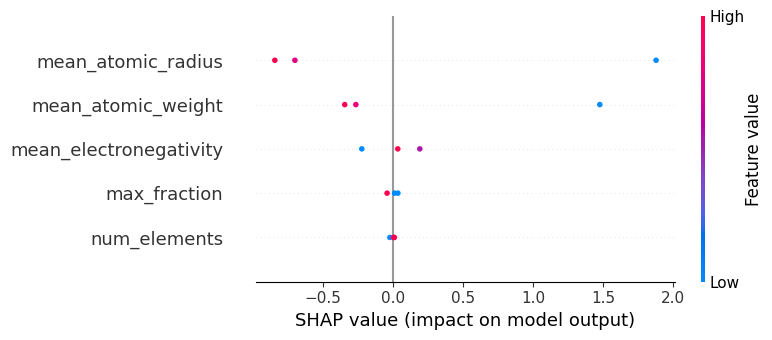

In [14]:
# Explain why the model made predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot shows feature importance visually
shap.summary_plot(shap_values, X_test)
